# Deep Q-Networks

In this assignment you will implement deep q-learning and test this algorithm on the Frozen-lake environment. This assigment asks you to use Tensorflow to implement a DQN, if you are unframiliar for Tensorflow I suggest you take a look [here](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/01_Simple_Linear_Model.ipynb) to get a general idea of how it works. After that it might be helpful to look into [tf.keras](https://www.tensorflow.org/guide/keras) which makes it easier to define networks.

In [2]:
import os
import numpy as np
import numpy.random as npr
import random
import matplotlib.pyplot as plt
import copy
from collections import defaultdict, namedtuple
from itertools import count
from more_itertools import windowed
from tqdm import tqdm

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.keras import layers

from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

plt.style.use('ggplot')

### $\epsilon$-Greedy Decay

In [3]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p) 

### $\epsilon$-Greedy

In [4]:
def e_greedy(state, epsilon, action_space, Qs, sess):
    probs = np.zeros(action_space)
    probs.fill(epsilon/action_space)

    action = np.argmax(Qs[0])
    probs[action] = 1 - epsilon + (epsilon/action_space)
    
    return probs

### Replay Buffer

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, size):
        '''
        Replay buffer used to store transition experiences. Experiences will be removed in a 
        FIFO manner after reaching maximum buffer size.
        
        Args:
            - size: Maximum size of the buffer.
        '''
        self.size = size
        self.memory = list()
        self.idx = 0
        
    def add(self, *args):
        if len(self.memory) < self.size:
            self.memory.append(None)
        self.memory[self.idx] = Transition(*args)
        self.idx = (self.idx + 1) % self.size
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### Step 1:

Implement the necessary Tensorflow operations for a Deep Q-Network. This should include the following:
1. A placeholder variable to take state input, a placeholder variable for target q-values, and a placeholder varaible for the selected actions; see [tf.placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder). You will also probably want to transform the input for selected actions into a one hot representation, see [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot).
1. Any number of fully connected layers which take the state as input and outputs the q-values for each possible action. You should only need a few small fully connected layers as the environments are relatively simple. I used 3 fully connected layers but you could probably get away with using fewer. I find the best way to create layers in tensorflow is to use [tf.slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) but a lot of people like to use [tf.keras](https://www.tensorflow.org/guide/keras). Feel free to use either of these APIs or just vanilla Tensorflow.
3. A prediction operation which returns the index of the best action, see [tf.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax).
4. Operations to compute the loss. A common loss function used for DQNs is [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) but for simple environments it is sufficient to just used MSE, also referred to as TD error:
$$
\begin{align}
    MSE = \frac{\sum_{i=1}^n (Q_i^{target} - Q_i^{estimate})^2)}{n}
\end{align}
$$
4. A optimizer to minimize the loss, i.e. [SGD](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer), [RMSProp](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer), [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer). The most commonly used optimizer these days is Adam so you should probably use that one but it is not required. Don't forget to create an operation which uses the optimizer to minimize the loss.

In [6]:
class DQN(object):
    def __init__(self, state_shape, action_shape, graph):
        '''
        Deep Q-Network Tensorflow model.
        
        Args:
            - state_shape: Input state shape 
            - action_shape: Output action shape
        '''
        self.state_shape = state_shape
        self.action_shape = action_shape
        
        with graph.as_default():
            # placeholders
            self.inputs = tf.placeholder(name = "inputs", shape = [1, 16], dtype = tf.float32)
            self.action = tf.placeholder(shape = [None, 4], dtype = tf.float32)
            
            self.Qout = self.build_model()
            
            self.targetQ = tf.placeholder(shape = [1,4], dtype = tf.float32)
            self.loss = tf.losses.mean_squared_error(self.Qout, self.targetQ)
            self.train = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(self.loss)
        
    # Multi-Layer perceptron
    def build_model(self):
        fc1 = tf.layers.dense(self.inputs, 16, activation = tf.nn.relu)
        fc2 = tf.layers.dense(fc1, 32, activation = tf.nn.relu)
        model = tf.layers.dense(fc2, 4)
    
        return model

### One-Hot vector

In [7]:
def preprocess(state, state_space = 16):
    one_hot = np.zeros(state_space, 'uint8')
    one_hot[state] = 1
    return one_hot

### Step 2: 

Implement the following method which will be used when optimizing the model. The optimize_model method should compute the target Q-values from the batch and use the optimizer op created in the previous exercise. Given the randomly sampled batch $(s_t, a_t, r_t, s'_t, d_t)$, where $d_t$ is a boolean indicating if the episode terminated at time $t$, we can compute the target Q-value used in the update as follows:

$$
\begin{align}
    Q_i^{target} = 
        \begin{cases}
            r_i & \text{if $d_t = True$} \\
        r_i + \gamma \underset{a'}{\max} \hat{Q}(s_{i+1}, a'; \theta) & \text{otherwise}
        \end{cases} \\
\end{align}
$$

**Note:** We are using a target network, $\hat{Q}$, to compute the target q-values in order to stabalize training.

In [8]:
def optimize_model(session, policy_net, target_net, batch, gamma):
    '''
    Calculates the target Q-values for the given batch and uses them to update the model.
    
    Args:
        - session: Tensorflow session
        - policy_net: Policy DQN model
        - target_net: DQN model used to generate target Q-values
        - batch: Batch of experiences uesd to optimize model
        - gamma: Discount factor
    '''
    
    for state,action,next_state,reward,done in batch:
        Q = session.run(policy_net.Qout, feed_dict = {policy_net.inputs : [state]})        
        targetQ = session.run(target_net.Qout, feed_dict = {target_net.inputs : [next_state]})
        
        if done:  
            # update
            target = reward
        else:
            target = reward + gamma * np.max(targetQ[0])
            
        Q[0][action] = target
        action_one_hot = preprocess(action, state_space = 4)
        session.run(policy_net.train, feed_dict = {policy_net.inputs : [state], policy_net.targetQ : Q})

These methods are used to set the target network weights to the policy network weights. You can do this by either copying the policy networks weights over to the target network every n timesteps or by updating the target network weights a small amount at each timestep. The latter of which tends to be more stable and is therefor used below. `update_target_graph_op` creates the various `tf.assign` operations and `update_target` calls these operations. 

In [9]:
def update_target_graph_op(tf_vars, tau):
    '''
    Creates a Tensorflow op which updates the target model towards the policy model by a small amount.
    
    Args:
        - tf_vars: All trainable variables in the Tensorflow graph
        - tau: Amount to update the target model
    '''
    total_vars = len(tf_vars)
    update_ops = list()
    for idx,var in enumerate(tf_vars[0:total_vars//2]):
        op = tf_vars[idx + total_vars//2].assign((var.value()*tau) + \
                                                 ((1-tau)*tf_vars[idx+total_vars//2].value()))
        update_ops.append(op)
    return update_ops

def update_target(session, update_ops):
    '''
    Calls each update op to update the target model.
    
    Args:
        - session: Tensorflow session
        - update_ops: The update ops which moves the target model towards the policy model
    '''
    for op in update_ops:
        session.run(op)

### Step 3:

Implement the below method to train the model in the given environment. You should choose actions in a $\epsilon$-greedy fashion while annealing $\epsilon$ over time as we did in the previous assignment.

In [10]:
def train(env, num_episodes=500, gamma=0.99, batch_size=64,
          annealing_steps=1000, s_epsilon=1.0, f_epsilon=0.1):
    '''
    DQN algorithm
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - batch_size: Number of experiences in a batch
        - annealing_steps: The number of steps to anneal epsilon over
        - s_epsilon: The initial epsilon value for e-greedy action selection
        - f_epsilon: The final epsilon value for the e-greedy action selection
        
    Returns: (policy_net, episode_rewards)
        - policy_net: Trained DQN model
        - episode_rewards: Numpy array containing the reward of each episode during training
    '''
    
    graph1 = tf.Graph()
    
    policy_net = DQN(env.observation_space.n, env.action_space.n, graph1)
    target_net = DQN(env.observation_space.n, env.action_space.n, graph1)
    
    target_ops = update_target_graph_op(tf.trainable_variables(), 0.1)
    
    # initialize a experience buffer
    memory = ReplayMemory(20000)

    exp = LinearSchedule(annealing_steps, f_epsilon, s_epsilon)
    
    total_steps = 0
    episode_rewards = np.zeros(num_episodes)
    max_steps = 50
    tf.reset_default_graph()
    pre_train_steps = 2000
    
    with tf.Session(graph = graph1) as sess:
         
        sess.run(tf.global_variables_initializer())
        
        for episode in range(num_episodes):
            
            # initialize sequence
            state = env.reset()
            # preprocess sequence
            state = preprocess(state)
            episode_steps = 0
            done = False

            if episode % 100 == 0:
                print("Episode: {}".format(episode))
        
            # agent is allowed to take a fixed number of steps
            while episode_steps < max_steps:
                
                episode_steps += 1
                total_steps += 1
                
                # epsilon decay till max annealing steps is reached
                eps = exp.value(total_steps)

                Qs = sess.run(policy_net.Qout, feed_dict = {policy_net.inputs : [state]})
                
                # select action based on the learning network output
                action_probs = e_greedy(state, eps, env.action_space.n, Qs, sess)
                action = np.random.choice(np.arange(env.action_space.n), p=action_probs)

                # take action and get observations
                next_state, reward, done, _ = env.step(action)

                # preprocess next_state
                next_state_one_hot = preprocess(next_state)

                # add reward to list of all rewards
                episode_rewards[episode] += reward
             
                # add experience to buffer
                memory.add(state, action, next_state_one_hot, reward, done)
                
                if total_steps > batch_size:
                    minibatch = memory.sample(batch_size)
                    optimize_model(sess, policy_net, target_net, minibatch, gamma)
                    update_target(sess, target_ops)

                state = next_state_one_hot
        
                if done:
                    break

    return policy_net, episode_rewards

#### Test your implentation on the Frozen-lake (both slippery and not slippery) environment. You should plot the episode rewards over time. It might be helpful to smooth this curve over a time window of 100 episodes in order to get  a more clear picture of the learning process.

In [11]:
def plot_moving_avg(values, window_size=100):
    csum = np.cumsum(values)
    csum[window_size:] = csum[window_size:] - csum[:-window_size]
    move_avg = csum[window_size-1:] / window_size

    plt.figure()
    plt.plot(move_avg)

Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400


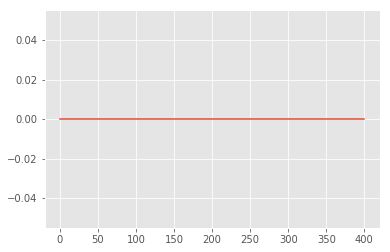

In [12]:
frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=False)
network, rewards = train(frozen_lake_env, num_episodes = 500)
plot_moving_avg(rewards)

In [412]:
print(rewards)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400


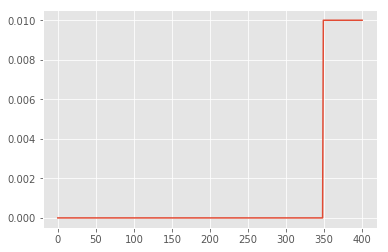

In [461]:
slippery_frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
network, rewards = train(frozen_lake_env, num_episodes = 500)
plot_moving_avg(rewards)